In [7]:
import os
import numpy as np
import skimage
from skimage import io
from skimage import color
from skimage import transform

from random import shuffle

import matplotlib.pyplot as plt 
import io
import pickle
import threading
%matplotlib inline

Цель данной работы - получить базовые навыки обработки изображений и видео.

Входные данные представляют собой набор видео. Каждое видео представлено в виде отдельной директории, хранящей последовательность кадров видео в формате JPEG [NNNN].jpg + файл timestamp.txt, хранящий информацию о временных метках (в мс) каждого кадра. Директория видео имеет следующий формат: [person ID]\_[session ID]\_[phrase ID]\_\*, где [phrase ID] состоит из цифр, произнесенных пользователем.

Для каждого кадра имеется файл [].landmarks, хранящий координаты характеристических точек в соотстветвии с рисунком:
![title](img/figure_68_markup.jpg)


In [2]:
# Функция загрузки временных меток видео
def read_timestamps(timestamps_filename):
    timestamps = []
    if not os.path.isfile(timestamps_filename):
        print("WARNING! can't open timestamps file: " + timestamps_filename)
        return []
    timestamps_lines = [l.strip() for l in open(timestamps_filename).readlines()]
    timestamps_raw = []
    for l in timestamps_lines:
        timestamps_raw = timestamps_raw + l.split(' ')
    if len(timestamps_raw) % 2 != 0:
        print("WARNING! can't parse timestamps file: " + timestamps_filename)
        return []
    for i in range(0, int(len(timestamps_raw)/2)):
        if ':' not in timestamps_raw[i*2]:
            print("WARNING! can't parse timestamps file: " + timestamps_filename + ", ts: " + timestamps_raw[i*2])
            return []
        timestamps.append([timestamps_raw[i*2].split(':')[0], float(timestamps_raw[i*2 + 1])])
    return timestamps

In [3]:
# Функция загрузки разметки характеристических точек лица
def read_landmarks(landmarks_filename):
    if not os.path.isfile(landmarks_filename):
        print("WARNING! can't open timestamps file: " + landmarks_filename)
        return np.array([])
    landmarks = [[float(l.split('\t')[0]), float(l.split('\t')[1])] for l in open(landmarks_filename).readlines()]
    return np.array(landmarks)

<b>Задание 1.</b> Прочитать любую картинку + landmarks из любого видео при помощи skimage и отрисовать при помощи matplotlib

In [13]:
work_dir = "data/"
video_dir =  work_dir + "0_raw_video/"

#------ TODO ---------------

#---------------------------


<b>Задание 2.</b> Провести следующую цепочку преобразований для видео:

- Прочитать изображения в черно-белом формате
- Повернуть изображение так, чтобы глаза находились строго горизонтально
- Вырезать область губ с разрешением 100x60
- Оставить то

Аналогичные преобразование необходимо сделать и с landmarks таким образом, чтобы 

In [6]:
def process_sessions(sessions, results_data_path):
    
    for session in sessions:
        timestamps = read_timestamps(session + "/timestamp.txt")

        image_shape = np.array([100, 60])
        landmarks_num = 68
        landmarks_mouth_num = 20

        data_img = np.zeros([len(timestamps), image_shape[0], image_shape[1]], dtype=np.float32)
        data_lm =  np.zeros([len(timestamps), landmarks_mouth_num, 2], dtype=np.float32)
        data_ts =  np.zeros([len(timestamps)], dtype=np.float32)
        frames = []

        

        session_name = session[session.rfind('/')+1:]
        print ("PROCESS: " + session_name + " (id: " + str(os.getpid()) + ")")

        
        dist_eyes_0 = 1
        crop_width_0 = 1
        max_time = 0
        counter = 0
        
        try:
            for frame, time in timestamps:
                if time <= max_time:
                    continue
                max_time = time
                image_filename = session + "/" + frame + ".jpg"
                if not os.path.isfile(image_filename):
                    image_filename = session + "/" + frame + ".jpeg"
                if not os.path.isfile(image_filename):
                    continue

                lm = read_landmarks(image_filename + ".landmarks")
                if (lm.shape[0] != landmarks_num):
                    continue
                
                # ------ TODO ---------------------------
                # 1. Прочитать изображение
                # 2. Повернуть
                # 3. Вырезать изображение рта            
                # ---------------------------------------
                image_gray = skimage.io.imread(image_filename, as_grey=True)
                #print(image_gray.dtype)

                crop_coeff = 100./60.

                mean_image = np.array([image_gray.shape[1]/2, image_gray.shape[0]/2])

                #calculate rotation angel
                mean_left_eye = np.mean(lm[36:42,:], axis=0)
                mean_right_eye = np.mean(lm[42:48,:], axis=0)
                dist_eye = np.sqrt(np.sum((mean_right_eye - mean_left_eye) ** 2))
                dist_mouth = np.sqrt(np.sum((lm[48,:] - lm[54,:]) ** 2))

                if (counter == 0):
                    dist_eyes_0 = dist_eye
                    crop_width_0 = dist_mouth * crop_coeff

                crop_width = crop_width_0 * (dist_eye / dist_eyes_0)
                crop_height = crop_width * (image_shape[1] / image_shape[0])


                # rotate
                rotate_angel_rad = -np.arccos((mean_right_eye - mean_left_eye)[0]/dist_eye)
                rotate_angel = 180 * (rotate_angel_rad / np.pi)
                rotate_matrix = np.array([[np.cos(rotate_angel_rad), -np.sin(rotate_angel_rad)],
                                          [np.sin(rotate_angel_rad), np.cos(rotate_angel_rad)]])
                lm = np.matmul(lm - mean_image, rotate_matrix) + mean_image
                image_gray = skimage.transform.rotate(image_gray, rotate_angel)

                lm_mouth_mean = np.mean(lm[48:68,:], axis=0)

                # crop
                crop_bound =np.array([[ int(lm_mouth_mean[0] - crop_width * 0.5), int(lm_mouth_mean[1] - crop_height * 0.5) ],
                                      [ int(lm_mouth_mean[0] + crop_width * 0.5), int(lm_mouth_mean[1] + crop_height * 0.5) ]])

                
                data_img[counter,:,:] = skimage.transform.resize(image_gray[crop_bound[0][1]:crop_bound[1][1], crop_bound[0][0]:crop_bound[1][0]], [image_shape[1],image_shape[0]], mode='constant').transpose()
                scale_factor = np.array([image_shape[0]/float(crop_bound[1][0] - crop_bound[0][0]), image_shape[1]/float(crop_bound[1][1] - crop_bound[0][1])])
                data_lm[counter,:,:] = (lm[48:68,:] - crop_bound[0]) * scale_factor
                data_ts[counter] = time

                #lm_indices = data_lm[counter,:,:].astype(dtype=np.int32)
                #for indx in lm_indices:
                #    data_img[counter, indx[0]-1:indx[0]+1, indx[1]-1:indx[1]+1] = 0
                #plt.imshow(image_gray[crop_bound[0][1]:crop_bound[1][1], crop_bound[0][0]:crop_bound[1][0]], cmap='gray')
                #plt.imshow(data_img[counter,:,:].transpose(), cmap='gray')

                frames.append(frame)
                counter = counter + 1
                #break
            
            data_img = np.resize(data_img, [counter, image_shape[0], image_shape[1]])
            data_lm =  np.resize(data_lm,  [counter, landmarks_mouth_num, 2])
            data_ts =  np.resize(data_ts,  [counter, 1])
            
            # сохраняем данные в бинарный файл при помощи библиотеки pickle
            with open(results_data_path + session_name + ".pickle", "wb") as f:
                pickle.dump(data_img, f)
                pickle.dump(data_lm, f)
                pickle.dump(data_ts, f)
                pickle.dump(frames, f)
        except:
            print ("ERROR! can't process session: " + session_name)

In [7]:
list_filename = "H:\\bases\\bimodal_ld_cross_channel\\video_ALL\\raw_test\\_list_good_tracks_no_win.txt"
results_data_path = "\\\\ovid-gpu-02\\media\\data\\kudashev\\summer_school\\data\\lipreading\\1_video_lips\\test\\"
list_sessions = [l.strip() for l in open(list_filename).readlines()]

threads_num = 8

sessions_num = len(list_sessions)

threads = []
for t in range(0,threads_num):
    sessions_thr = list_sessions[t::threads_num]
    thr = threading.Thread(target=process_sessions, args=(sessions_thr,results_data_path,))
    thr.start()
    print("thread " + str(t) + " started , sessions num: " + str(len(sessions_thr)))
    threads.append(thr)

for thr in threads:
    thr.join()
    
print("FINISHED")


thread 0 started , sessions num: 364
thread 1 started , sessions num: 364
thread 2 started , sessions num: 364
thread 3 started , sessions num: 364PROCESS: F0005_01_25981_iPhone_6s (id: 8172)

PROCESS: F0005_01_4351796082_iPhone_6s (id: 8172)PROCESS: F0005_01_54398_iPhone_6s (id: 8172)thread 4 started , sessions num: 364PROCESS: F0005_01_63470_iPhone_6s (id: 8172)

PROCESS: F0005_01_70216_iPhone_6s (id: 8172)PROCESS: F0005_01_9761823504_iPhone_6s (id: 8172)

PROCESS: F0005_02_17538_Android_htc (id: 8172)PROCESS: F0005_02_29640_Android_htc (id: 8172)

thread 5 started , sessions num: 363


thread 6 started , sessions num: 363
thread 7 started , sessions num: 363
PROCESS: F0005_03_34786_Android_SM_Gal_J3 (id: 8172)
PROCESS: F0005_02_9730581624_Android_htc (id: 8172)
PROCESS: F0005_02_57049_Android_htc (id: 8172)
PROCESS: F0005_02_4067593812_Android_htc (id: 8172)
PROCESS: F0005_02_62138_Android_htc (id: 8172)
PROCESS: F0005_03_20174_Android_nexus (id: 8172)
PROCESS: F0005_02_4910725836_A

PROCESS: F0020_01_2637015489_iPhone_6s (id: 8172)
PROCESS: F0015_03_74126_Android_nexus (id: 8172)
PROCESS: F0015_03_42950_Android_nexus (id: 8172)
PROCESS: F0020_01_23679_iPhone_6s (id: 8172)
PROCESS: F0020_01_43652_iPhone_6s (id: 8172)
PROCESS: F0020_02_42365_iPhone_iphone6 (id: 8172)
PROCESS: F0015_03_9263475180_Android_nexus (id: 8172)
PROCESS: F0020_01_48150_iPhone_6s (id: 8172)
PROCESS: F0015_03_96157_Android_SM_Gal_J3 (id: 8172)
PROCESS: F0020_01_87901_iPhone_6s (id: 8172)
PROCESS: F0020_02_1253068479_Android_htc (id: 8172)
PROCESS: F0020_02_1392408567_iPhone_iphone6 (id: 8172)
PROCESS: F0020_02_1894372056_iPhone_iphone6 (id: 8172)
PROCESS: F0020_02_95230_Android_htc (id: 8172)
PROCESS: F0020_02_4029763518_iPhone_iphone6 (id: 8172)
PROCESS: F0020_02_04279_iPhone_iphone6 (id: 8172)
PROCESS: F0020_02_5037649281_Android_htc (id: 8172)
PROCESS: F0020_01_8102574936_iPhone_6s (id: 8172)
PROCESS: F0020_03_5267981034_iPhone_6s (id: 8172)
PROCESS: F0020_02_51386_iPhone_iphone6 (id: 8172)

PROCESS: F0029_03_1230694587_Android_SM (id: 8172)
PROCESS: F0031_02_1392408567_iPhone_iphone6 (id: 8172)
PROCESS: F0031_01_98264_iPhone_Iphone5 (id: 8172)
PROCESS: F0031_02_5037649281_Android_htc (id: 8172)
PROCESS: F0031_02_89071_iPhone_iphone6 (id: 8172)
PROCESS: F0031_02_42365_iPhone_iphone6 (id: 8172)
PROCESS: F0031_03_39452_iPhone_6s (id: 8172)
PROCESS: F0031_02_51386_iPhone_iphone6 (id: 8172)
PROCESS: F0031_01_4523869701_iPhone_Iphone5 (id: 8172)
PROCESS: F0031_02_46783_Android_htc (id: 8172)
PROCESS: F0032_01_70531_iPhone_Iphone5 (id: 8172)
PROCESS: F0031_02_59021_Android_htc (id: 8172)
PROCESS: F0031_02_95230_Android_htc (id: 8172)
PROCESS: F0031_03_94518_iPhone_6s (id: 8172)
PROCESS: F0031_03_2473581960_iPhone_6s (id: 8172)
PROCESS: F0031_03_17806_iPhone_6s (id: 8172)
PROCESS: F0032_02_42365_iPhone_iphone6 (id: 8172)
PROCESS: F0032_02_04279_iPhone_iphone6 (id: 8172)
PROCESS: F0031_03_4039618572_iPhone_6s (id: 8172)
PROCESS: F0032_01_2593068741_iPhone_Iphone5 (id: 8172)
PROCES

PROCESS: F0050_02_03924_Android_htc (id: 8172)
PROCESS: F0042_03_4306759182_Android_SM_Gal_J3 (id: 8172)
PROCESS: F0042_03_69570_Android_SM_Gal_J3 (id: 8172)
PROCESS: F0050_03_40826_iPhone_6s (id: 8172)
PROCESS: F0050_01_15603_Android_SM (id: 8172)
PROCESS: F0042_03_84312_Android_SM_Gal_J3 (id: 8172)
PROCESS: F0042_01_4615028739_iPhone_Iphone5 (id: 8172)
PROCESS: F0050_01_19083_Android_SM (id: 8172)
PROCESS: F0050_01_3710859426_Android_SM (id: 8172)
PROCESS: F0050_02_1392408567_iPhone_iphone6 (id: 8172)
PROCESS: F0050_02_2691345807_Android_htc (id: 8172)
PROCESS: F0051_01_2637015489_iPhone_6s (id: 8172)
PROCESS: F0050_02_0578342619_Android_htc (id: 8172)
PROCESS: F0050_01_1460753928_Android_SM (id: 8172)
PROCESS: F0050_02_0582397146_Android_htc (id: 8172)
PROCESS: F0042_02_04279_iPhone_iphone6 (id: 8172)
PROCESS: F0051_02_17538_Android_htc (id: 8172)
PROCESS: F0042_02_4910725836_Android_htc (id: 8172)
PROCESS: F0050_02_17658_Android_htc (id: 8172)
PROCESS: F0050_02_04279_iPhone_iphone6

PROCESS: F0068_03_8726039514_Android_htc (id: 8172)
PROCESS: F0068_03_13740_Android_htc (id: 8172)
PROCESS: F0073_02_26389_Android_nexus (id: 8172)
PROCESS: F0068_03_14590_Android_htc (id: 8172)
PROCESS: F0068_03_9745031826_Android_htc (id: 8172)
PROCESS: F0068_01_70296_iPhone_6s (id: 8172)
PROCESS: F0068_03_79428_iPhone_iphone6 (id: 8172)
PROCESS: F0073_03_3098451762_Android_htc (id: 8172)
PROCESS: F0068_03_83971_iPhone_iphone6 (id: 8172)
PROCESS: F0068_03_89265_Android_htc (id: 8172)
PROCESS: F0069_01_41853_iPhone_6s (id: 8172)
PROCESS: F0069_01_70531_iPhone_6s (id: 8172)
PROCESS: F0069_01_4523869701_iPhone_6s (id: 8172)
PROCESS: F0068_02_2104796583_Android_SM_Gal_J3 (id: 8172)
PROCESS: F0069_02_0571928643_Android_nexus (id: 8172)
PROCESS: F0069_02_3017568429_Android_nexus (id: 8172)
PROCESS: F0069_02_7804526931_Android_nexus (id: 8172)
PROCESS: F0069_01_98264_iPhone_6s (id: 8172)
PROCESS: F0069_01_70296_iPhone_6s (id: 8172)
PROCESS: F0073_03_7194053286_Android_htc (id: 8172)
PROCESS

PROCESS: F0117_03_18246_Android_SM_Gal_J3 (id: 8172)
PROCESS: F0117_03_42051_Android_nexus (id: 8172)
PROCESS: F0119_02_86913_Android_nexus (id: 8172)
PROCESS: F0117_02_0582397146_Android_htc (id: 8172)
PROCESS: F0119_01_80561_iPhone_6s (id: 8172)
PROCESS: F0117_03_79261_Android_nexus (id: 8172)
PROCESS: F0095_03_83971_iPhone_iphone6 (id: 8172)
PROCESS: F0117_03_90735_Android_SM_Gal_J3 (id: 8172)
PROCESS: F0095_03_6382074195_iPhone_iphone6 (id: 8172)
PROCESS: F0119_03_38750_iPhone_6s (id: 8172)
PROCESS: F0117_03_3647285901_Android_nexus (id: 8172)
PROCESS: F0119_01_32074_Android_SM (id: 8172)
PROCESS: F0119_02_35782_Android_SM_Gal_J3 (id: 8172)
PROCESS: F0119_01_6519347208_iPhone_6s (id: 8172)
PROCESS: F0117_02_03924_Android_htc (id: 8172)
PROCESS: F0130_01_1935482760_Android_SM (id: 8172)
PROCESS: F0117_02_51386_iPhone_iphone6 (id: 8172)
PROCESS: F0119_02_91082_Android_nexus (id: 8172)
PROCESS: F0119_01_9726431850_Android_SM (id: 8172)
PROCESS: F0117_02_2691345807_Android_htc (id: 817

PROCESS: F0168_03_0586934721_Android_htc (id: 8172)
PROCESS: F0157_03_4532091867_iPhone_iphone6 (id: 8172)
PROCESS: F0154_02_4980627135_Android_htc (id: 8172)
PROCESS: F0168_01_35721_iPhone_6s (id: 8172)
PROCESS: F0157_01_0435891276_iPhone_6s (id: 8172)
PROCESS: F0169_01_7419068325_iPhone_6s (id: 8172)
PROCESS: F0169_03_08192_Android_SM_Gal_J3 (id: 8172)
PROCESS: F0169_02_4950631278_Android_htc (id: 8172)
PROCESS: F0169_01_02675_Android_SM (id: 8172)
PROCESS: F0168_03_53061_iPhone_iphone6 (id: 8172)
PROCESS: F0168_01_0768123549_iPhone_6s (id: 8172)
PROCESS: F0169_03_7391246805_Android_nexus (id: 8172)
PROCESS: F0154_03_23654_Android_SM_Gal_J3 (id: 8172)
PROCESS: F0169_01_35721_iPhone_6s (id: 8172)
PROCESS: F0157_01_7412980653_Android_SM (id: 8172)
PROCESS: F0169_01_49608_iPhone_6s (id: 8172)
PROCESS: F0168_03_36245_Android_htc (id: 8172)
PROCESS: F0169_03_07634_Android_SM_Gal_J3 (id: 8172)
PROCESS: F0169_02_4029763518_iPhone_iphone6 (id: 8172)
PROCESS: F0154_03_6987543021_Android_SM_Ga

PROCESS: F0181_02_94863_Android_nexus (id: 8172)
PROCESS: F0182_03_83971_iPhone_iphone6 (id: 8172)
PROCESS: F0182_03_36245_Android_htc (id: 8172)
PROCESS: F0182_01_59146_Android_SM (id: 8172)
PROCESS: F0181_01_8076135429_Android_SM (id: 8172)
PROCESS: F0172_02_05961_Android_htc (id: 8172)
PROCESS: F0181_02_82673_Android_SM_Gal_J3 (id: 8172)
PROCESS: F0173_02_25647_Android_htc (id: 8172)
PROCESS: F0191_01_61243_iPhone_6s (id: 8172)
PROCESS: F0182_01_2981306754_iPhone_6s (id: 8172)
PROCESS: F0182_02_04837_Android_SM_Gal_J3 (id: 8172)
PROCESS: F0182_03_82493_Android_htc (id: 8172)
PROCESS: F0173_03_1864903275_iPhone_6s (id: 8172)
PROCESS: F0172_02_4263908751_Android_htc (id: 8172)
PROCESS: F0182_01_51783_Android_SM (id: 8172)
PROCESS: F0191_02_04837_Android_SM_Gal_J3 (id: 8172)
PROCESS: F0182_02_5926870431_Android_nexus (id: 8172)
PROCESS: F0191_01_5023164879_iPhone_6s (id: 8172)
PROCESS: F0181_02_20759_Android_nexus (id: 8172)
PROCESS: F0173_03_9327861450_Android_SM (id: 8172)
PROCESS: F

PROCESS: F0199_02_4950631278_Android_htc (id: 8172)
PROCESS: F0201_01_86794_Android_SM (id: 8172)
PROCESS: F0199_03_72486_Android_nexus (id: 8172)
PROCESS: F0199_01_1052698347_Android_nexus (id: 8172)
PROCESS: F0191_02_68143_Android_nexus (id: 8172)
PROCESS: F0199_02_71045_Android_htc (id: 8172)
PROCESS: F0200_01_27413_Android_SM_Gal_J3 (id: 8172)
PROCESS: F0197_01_37851_Android_nexus (id: 8172)
PROCESS: F0201_02_41302_Android_htc (id: 8172)
PROCESS: F0199_03_1463925078_Android_SM_Gal_J3 (id: 8172)
PROCESS: F0200_03_62045_iPhone_iphone6 (id: 8172)
PROCESS: F0200_01_7546301298_Android_nexus (id: 8172)
PROCESS: F0199_01_37851_Android_nexus (id: 8172)
PROCESS: F0191_03_4532091867_iPhone_iphone6 (id: 8172)
PROCESS: F0199_03_6482310759_Android_nexus (id: 8172)
PROCESS: F0201_02_9416235780_Android_htc (id: 8172)
PROCESS: F0197_02_1340768592_Android_SM (id: 8172)
PROCESS: F0199_02_1894372056_iPhone_iphone6 (id: 8172)
PROCESS: F0201_01_21053_Android_SM (id: 8172)
PROCESS: F0200_01_1690483752_A

PROCESS: M0006_03_4697803125_Android_SM_Gal_J3 (id: 8172)
PROCESS: M0002_02_89254_Android_htc (id: 8172)
PROCESS: M0002_03_71638_Android_nexus (id: 8172)
PROCESS: M0001_01_54398_iPhone_6s (id: 8172)
PROCESS: M0002_03_5602743918_Android_SM_Gal_J3 (id: 8172)
PROCESS: M0004_02_89071_iPhone_iphone6 (id: 8172)
PROCESS: M0002_03_9385741620_Android_SM_Gal_J3 (id: 8172)
PROCESS: M0006_03_89462_Android_nexus (id: 8172)
PROCESS: M0002_03_5873419602_Android_nexus (id: 8172)
PROCESS: M0001_03_05849_Android_SM_Gal_J3 (id: 8172)
PROCESS: M0004_01_4351796082_iPhone_6s (id: 8172)
PROCESS: M0004_03_45921_Android_SM_Gal_J3 (id: 8172)
PROCESS: M0007_02_13856_Android_nexus (id: 8172)
PROCESS: M0004_01_1324670895_iPhone_6s (id: 8172)
PROCESS: M0001_02_27459_Android_SM (id: 8172)
PROCESS: M0004_01_9761823504_iPhone_6s (id: 8172)
PROCESS: M0004_01_25981_iPhone_6s (id: 8172)
PROCESS: M0007_02_58307_Android_SM_Gal_J3 (id: 8172)
PROCESS: M0006_01_1324670895_iPhone_6s (id: 8172)
PROCESS: M0001_03_59012_Android_S

PROCESS: M0028_03_5873419602_Android_nexus (id: 8172)
PROCESS: M0006_03_5734802691_Android_nexus (id: 8172)
PROCESS: M0016_01_23679_iPhone_6s (id: 8172)
PROCESS: M0007_02_7639814520_Android_nexus (id: 8172)
PROCESS: M0016_01_43652_iPhone_6s (id: 8172)
PROCESS: M0016_01_5326071948_iPhone_6s (id: 8172)
PROCESS: M0016_01_48150_iPhone_6s (id: 8172)
PROCESS: M0007_01_1324670895_iPhone_6s (id: 8172)
PROCESS: M0016_02_1763092458_iPhone_Iphone5 (id: 8172)
PROCESS: M0030_01_41853_iPhone_Iphone5 (id: 8172)
PROCESS: M0016_02_29150_Android_htc (id: 8172)
PROCESS: M0012_02_16073_Android_htc (id: 8172)
PROCESS: M0016_02_46783_Android_htc (id: 8172)
PROCESS: M0030_02_5037649281_Android_htc (id: 8172)
PROCESS: M0016_02_29507_iPhone_Iphone5 (id: 8172)
PROCESS: M0012_03_1576042983_Android_nexus (id: 8172)
PROCESS: M0016_02_9367254810_Android_htc (id: 8172)
PROCESS: M0016_02_34598_iPhone_Iphone5 (id: 8172)
PROCESS: M0007_02_16094_Android_nexus (id: 8172)
PROCESS: M0016_02_94862_Android_htc (id: 8172)
PRO

PROCESS: M0030_03_46972_Android_SM (id: 8172)
PROCESS: M0036_02_4029763518_iPhone_iphone6 (id: 8172)
PROCESS: M0036_03_3927810546_Android_SM (id: 8172)
PROCESS: M0038_03_36954_iPhone_6s (id: 8172)
PROCESS: M0037_01_62795_iPhone_Iphone5 (id: 8172)
PROCESS: M0033_01_2593068741_iPhone_Iphone5 (id: 8172)
PROCESS: M0038_03_92706_Android_SM (id: 8172)
PROCESS: M0028_02_46783_Android_htc (id: 8172)
PROCESS: M0036_03_85792_iPhone_6s (id: 8172)
PROCESS: M0037_01_43876_iPhone_Iphone5 (id: 8172)
PROCESS: M0037_02_2174905683_Android_htc (id: 8172)
PROCESS: M0036_03_92706_Android_SM (id: 8172)
PROCESS: M0036_03_1230694587_Android_SM (id: 8172)
PROCESS: M0037_01_4615028739_iPhone_Iphone5 (id: 8172)
PROCESS: M0028_03_03582_Android_SM_Gal_J3 (id: 8172)
PROCESS: M0039_01_4762598103_Android_htc (id: 8172)
PROCESS: M0033_02_1392408567_iPhone_iphone6 (id: 8172)
PROCESS: M0037_01_4762598103_Android_htc (id: 8172)
PROCESS: M0037_01_9375620841_iPhone_Iphone5 (id: 8172)
PROCESS: M0037_03_05937_Android_nexus (

PROCESS: M0039_02_89071_iPhone_iphone6 (id: 8172)
PROCESS: M0041_01_51902_iPhone_Iphone5 (id: 8172)
PROCESS: M0041_03_40826_iPhone_6s (id: 8172)
PROCESS: M0045_03_1854329706_iPhone_6s (id: 8172)
PROCESS: M0044_01_28961_Android_htc (id: 8172)
PROCESS: M0043_02_46783_Android_htc (id: 8172)
PROCESS: M0041_02_3910576824_Android_SM (id: 8172)
PROCESS: M0043_02_95230_Android_htc (id: 8172)
PROCESS: M0039_03_23895_Android_SM_Gal_J3 (id: 8172)
PROCESS: M0043_01_0762453891_Android_htc (id: 8172)
PROCESS: M0044_01_72613_iPhone_Iphone5 (id: 8172)
PROCESS: M0039_01_0594267381_Android_htc (id: 8172)
PROCESS: M0044_01_0762453891_Android_htc (id: 8172)
PROCESS: M0044_01_4682107593_iPhone_Iphone5 (id: 8172)
PROCESS: M0041_01_0594267381_Android_htc (id: 8172)
PROCESS: M0044_02_46783_Android_htc (id: 8172)
PROCESS: M0043_02_5037649281_Android_htc (id: 8172)
PROCESS: M0046_01_04391_Android_htc (id: 8172)
PROCESS: M0044_03_94518_iPhone_6s (id: 8172)
PROCESS: M0044_01_69047_iPhone_Iphone5 (id: 8172)
PROCES

PROCESS: M0049_02_0582397146_Android_htc (id: 8172)
PROCESS: M0053_02_24183_Android_SM (id: 8172)
PROCESS: M0049_03_3142985706_Android_nexus (id: 8172)
PROCESS: M0049_01_9307426185_iPhone_Iphone5 (id: 8172)
PROCESS: M0053_03_80426_Android_SM (id: 8172)
PROCESS: M0046_01_69175_Android_htc (id: 8172)
PROCESS: M0053_03_32054_iPhone_6s (id: 8172)
PROCESS: M0047_03_86071_Android_nexus (id: 8172)
PROCESS: M0054_02_4910725836_Android_htc (id: 8172)
PROCESS: M0049_02_1894372056_iPhone_iphone6 (id: 8172)
PROCESS: M0053_03_79618_iPhone_6s (id: 8172)
PROCESS: M0047_01_04391_Android_htc (id: 8172)
PROCESS: M0048_01_9307426185_iPhone_Iphone5 (id: 8172)
PROCESS: M0049_02_51386_iPhone_iphone6 (id: 8172)
PROCESS: M0046_02_29845_Android_htc (id: 8172)
PROCESS: M0053_01_48150_iPhone_6s (id: 8172)
PROCESS: M0054_02_4067593812_Android_htc (id: 8172)
PROCESS: M0047_01_5794182036_Android_htc (id: 8172)
PROCESS: M0049_03_2543781960_Android_nexus (id: 8172)
PROCESS: M0053_02_16058_iPhone_6s (id: 8172)
PROCESS

PROCESS: M0055_02_42365_iPhone_iphone6 (id: 8172)
PROCESS: M0058_02_42365_iPhone_iphone6 (id: 8172)
PROCESS: M0056_02_42365_iPhone_iphone6 (id: 8172)
PROCESS: M0058_03_14682_Android_SM_Gal_J3 (id: 8172)
PROCESS: M0057_03_2594680137_iPhone_6s (id: 8172)
PROCESS: M0056_03_03984_Android_SM (id: 8172)
PROCESS: M0057_03_02864_iPhone_6s (id: 8172)
PROCESS: M0058_03_18572_Android_nexus (id: 8172)
PROCESS: M0059_01_87901_iPhone_6s (id: 8172)
PROCESS: M0055_03_12763_Android_SM_Gal_J3 (id: 8172)
PROCESS: M0055_02_51386_iPhone_iphone6 (id: 8172)
PROCESS: M0056_03_8105932674_Android_SM (id: 8172)
PROCESS: M0058_03_3142985706_Android_nexus (id: 8172)
PROCESS: M0057_03_47908_Android_SM (id: 8172)
PROCESS: M0058_03_46025_Android_nexus (id: 8172)
PROCESS: M0057_03_8105932674_Android_SM (id: 8172)
PROCESS: M0055_03_6879204135_Android_nexus (id: 8172)
PROCESS: M0057_01_87901_iPhone_6s (id: 8172)
PROCESS: M0055_03_34786_Android_SM_Gal_J3 (id: 8172)
PROCESS: M0059_02_42365_iPhone_iphone6 (id: 8172)
PROCES

PROCESS: M0059_03_6987543021_Android_SM_Gal_J3 (id: 8172)
PROCESS: M0067_03_62045_iPhone_iphone6 (id: 8172)
PROCESS: M0062_03_53061_iPhone_iphone6 (id: 8172)
PROCESS: M0064_02_97063_Android_nexus (id: 8172)
PROCESS: M0060_03_62045_iPhone_iphone6 (id: 8172)
PROCESS: M0067_01_4523869701_iPhone_6s (id: 8172)
PROCESS: M0062_03_97642_Android_htc (id: 8172)
PROCESS: M0064_03_2738015469_iPhone_iphone6 (id: 8172)
PROCESS: M0064_03_6382074195_iPhone_iphone6 (id: 8172)
PROCESS: M0070_02_03271_Android_nexus (id: 8172)
PROCESS: M0062_01_2593068741_iPhone_6s (id: 8172)
PROCESS: M0064_02_0571928643_Android_nexus (id: 8172)
PROCESS: M0060_01_87901_iPhone_6s (id: 8172)
PROCESS: M0067_02_05469_Android_nexus (id: 8172)
PROCESS: M0070_02_5692438017_Android_SM_Gal_J3 (id: 8172)
PROCESS: M0060_03_02764_Android_htc (id: 8172)
PROCESS: M0064_03_89265_Android_htc (id: 8172)
PROCESS: M0067_02_15238_Android_SM_Gal_J3 (id: 8172)
PROCESS: M0064_03_14590_Android_htc (id: 8172)
PROCESS: M0062_02_21845_Android_nexus

PROCESS: M0072_03_83971_iPhone_iphone6 (id: 8172)
PROCESS: M0071_01_23985_iPhone_6s (id: 8172)
PROCESS: M0075_02_4258637190_Android_SM_Gal_J3 (id: 8172)
PROCESS: M0072_03_9745031826_Android_htc (id: 8172)
PROCESS: M0072_02_37528_Android_SM_Gal_J3 (id: 8172)
PROCESS: M0074_02_38907_Android_SM (id: 8172)
PROCESS: M0076_02_05469_Android_nexus (id: 8172)
PROCESS: M0071_01_7108563429_iPhone_6s (id: 8172)
PROCESS: M0075_02_3964071825_Android_SM_Gal_J3 (id: 8172)
PROCESS: M0071_02_05469_Android_nexus (id: 8172)
PROCESS: M0076_02_74096_Android_SM_Gal_J3 (id: 8172)
PROCESS: M0074_02_87621_Android_SM (id: 8172)
PROCESS: M0072_02_8719463205_Android_SM_Gal_J3 (id: 8172)
PROCESS: M0075_03_17625_Android_SM (id: 8172)
PROCESS: M0071_03_2738015469_iPhone_iphone6 (id: 8172)
PROCESS: M0074_03_4762093185_iPhone_6s (id: 8172)
PROCESS: M0076_03_2738015469_iPhone_iphone6 (id: 8172)
PROCESS: M0071_02_8643201957_Android_nexus (id: 8172)
PROCESS: M0074_02_54639_iPhone_6s (id: 8172)
PROCESS: M0075_03_8105932674

PROCESS: M0081_01_01294_iPhone_6s (id: 8172)
PROCESS: M0081_01_4789306251_iPhone_6s (id: 8172)
PROCESS: M0077_01_7108563429_iPhone_6s (id: 8172)
PROCESS: M0082_02_5692438017_Android_SM_Gal_J3 (id: 8172)
PROCESS: M0077_02_68502_Android_SM_Gal_J3 (id: 8172)
PROCESS: M0082_02_4602935718_Android_nexus (id: 8172)
PROCESS: M0081_02_05469_Android_nexus (id: 8172)
PROCESS: M0081_02_37528_Android_SM_Gal_J3 (id: 8172)
PROCESS: M0088_01_97842_Android_SM (id: 8172)
PROCESS: M0081_02_74096_Android_SM_Gal_J3 (id: 8172)
PROCESS: M0077_03_47908_Android_SM (id: 8172)
PROCESS: M0078_01_7108563429_iPhone_6s (id: 8172)
PROCESS: M0081_02_8719463205_Android_SM_Gal_J3 (id: 8172)
PROCESS: M0082_03_02764_Android_htc (id: 8172)
PROCESS: M0088_02_60487_Android_nexus (id: 8172)
PROCESS: M0082_03_2738015469_iPhone_iphone6 (id: 8172)
PROCESS: M0081_03_60189_Android_htc (id: 8172)
PROCESS: M0077_02_49826_Android_nexus (id: 8172)
PROCESS: M0089_01_3702149568_Android_SM (id: 8172)
PROCESS: M0078_01_6527480931_iPhone_6

float32
(95, 1)
[ 1912.]
0055


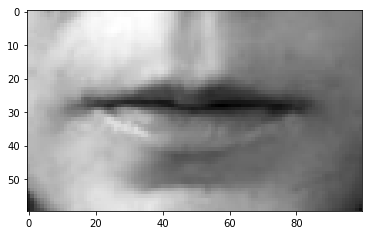

In [22]:
with open("\\\\ovid-gpu-02\\media\\data\\kudashev\\summer_school\\data\\lipreading\\train_2\\F0014_02_04279_iPhone_iphone6.pickle", "rb") as f:
    data_img_test = pickle.load(f)
    data_lm_test = pickle.load(f)
    data_ts_test = pickle.load(f)
    frames_test = pickle.load(f)

index = 55
plt.imshow(data_img_test[index,:,:].transpose(), cmap='gray')
print(data_img_test.dtype)
print(data_ts_test.shape)
print(data_ts_test[index])
print(frames_test[index])
test_path = "H:\\bases\\bimodal_ld_cross_channel\\video_ALL\\test\\"

#lm_indices = data_lm_test.astype(dtype=np.int32)
#for i in range(0, len(frames_test)):
#    for indx in lm_indices[i,:,:]:
#        data_img_test[i, indx[0]-2:indx[0]+2, indx[1]-2:indx[1]+1] = 0
#    skimage.io.imsave(test_path + frames_test[i] + ".png", data_img_test[i,:,:].transpose())

In [48]:
path_train = "H:\\bases\\bimodal_ld_cross_channel\\video_ALL\\raw_train\\"
ts = read_timestamps(path_train + "F034_03_8726039514_Android_htc\\timestamp.txt")
print(ts)

[['0000', 22.0], ['0001', 52.0], ['0002', 93.0], ['0003', 119.0], ['0004', 180.0], ['0005', 188.0], ['0006', 219.0], ['0007', 251.0], ['0008', 291.0], ['0009', 317.0], ['0010', 350.0], ['0011', 384.0], ['0012', 419.0], ['0013', 450.0], ['0014', 490.0], ['0015', 517.0], ['0016', 556.0], ['0017', 583.0], ['0018', 654.0], ['0019', 689.0], ['0020', 715.0], ['0021', 748.0], ['0022', 785.0], ['0023', 823.0], ['0024', 852.0], ['0025', 889.0], ['0026', 916.0], ['0027', 954.0], ['0028', 981.0], ['0029', 1017.0], ['0030', 1050.0], ['0031', 1087.0], ['0032', 1153.0], ['0033', 1181.0], ['0034', 1222.0], ['0035', 1247.0], ['0036', 1287.0], ['0037', 1314.0], ['0038', 1354.0], ['0039', 1383.0], ['0040', 1416.0], ['0041', 1449.0], ['0042', 1487.0], ['0043', 1513.0], ['0044', 1549.0], ['0045', 1582.0], ['0046', 1652.0], ['0047', 1684.0], ['0048', 1712.0], ['0049', 1744.0], ['0050', 1778.0], ['0051', 1812.0], ['0052', 1845.0], ['0053', 1884.0], ['0054', 1914.0], ['0055', 1952.0], ['0056', 1982.0], ['005

In [13]:
print(test.dtype)

float64
